<h2>Import packages and data</h2>

In [1]:
from scipy.io import netcdf
from scipy.stats import entropy
import similarity_measures as sim
import calculations as calc
import comparing as comp
import combining as comb
import plots
import numpy as np
import matplotlib as plt

In [2]:
nc_l3 = netcdf.netcdf_file("data/era-int_pl_1979-2019-mm-l3-u.nc")

In [3]:
nc_u_l30 = netcdf.netcdf_file("data/era-int_pl_1979-2019-mm-l30-u.nc")

In [4]:
nc_l70 = netcdf.netcdf_file("data/era-int_pl_1979-2019-mm-l70-u.nc")

In [5]:
nc_l300 = netcdf.netcdf_file("data/era-int_pl_1979-2019-mm-l300-u.nc")

In [6]:
plt.rcParams.update({'font.size': 25})

<h2>Derive QBO and prepare datasets</h2>

In [7]:
lon = calc.convert_coordinates_to_grid(nc_u_l30.variables["longitude"][:], 180)
lat = calc.convert_coordinates_to_grid(nc_u_l30.variables["latitude"][:], 0)

lon_step = 256 #Around the whole equator
lat_step = calc.convert_coordinates_to_grid(nc_u_l30.variables["latitude"][:], 0) - calc.convert_coordinates_to_grid(nc_u_l30.variables["latitude"][:], 5)


u_l30 = nc_u_l30.variables["u"]

#Deseasonalize
u_l30 = calc.deseasonalize_map(u_l30)

qbo_equator = calc.derive(u_l30[:, :, :, :], lat, lon, 0, lat_step, lon_step)

In [8]:
u_l70 = nc_l70.variables["u"]
u_l70 = calc.deseasonalize_map(u_l70)

In [9]:
u_l3 = nc_l3.variables["u"]
u_l3 = calc.deseasonalize_map(u_l3)

In [10]:
u_l300 = nc_l300.variables["u"]
u_l300 = calc.deseasonalize_map(u_l300)

<h1>Define functions and thresholds</h1>

In [11]:
measures = [sim.mutual_information, comp.invert(sim.manhattan_distance), comp.invert(sim.transfer_entropy)]

In [12]:
strength_threshold = 0.5

In [13]:
agreement_threshold = 0.8

In [14]:
agreement_func = comb.std

In [15]:
strength_func = comb.mean

In [16]:
scaling = comp.binning_to_100_bins

<h2>Compute agreement mask with MI, MD and TE</h2>

In [17]:
mask = calc.calculate_filtered_agreement_areas(u_l30, qbo_equator, measures, strength_threshold, agreement_threshold, strength_func=strength_func, agreement_func=agreement_func, scaling_func=scaling)

<h2>Compute Pearson's Correlation for data</h2>

In [18]:
pearson_map = calc.calculate_series_similarity(u_l30, qbo_equator, sim_func=sim.pearson_correlation)

<h2>Apply mask on map</h2>

In [19]:
filtered_pearson_map = calc.apply_mask_on_map(pearson_map, mask)

C:\Users\tousp\OneDrive\KIT\6. Semester\Bachelorarbeit\Climate-Similarity-Metrics\plots.py:675: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='mill', lon_0=30, resolution='l', ax=axis)


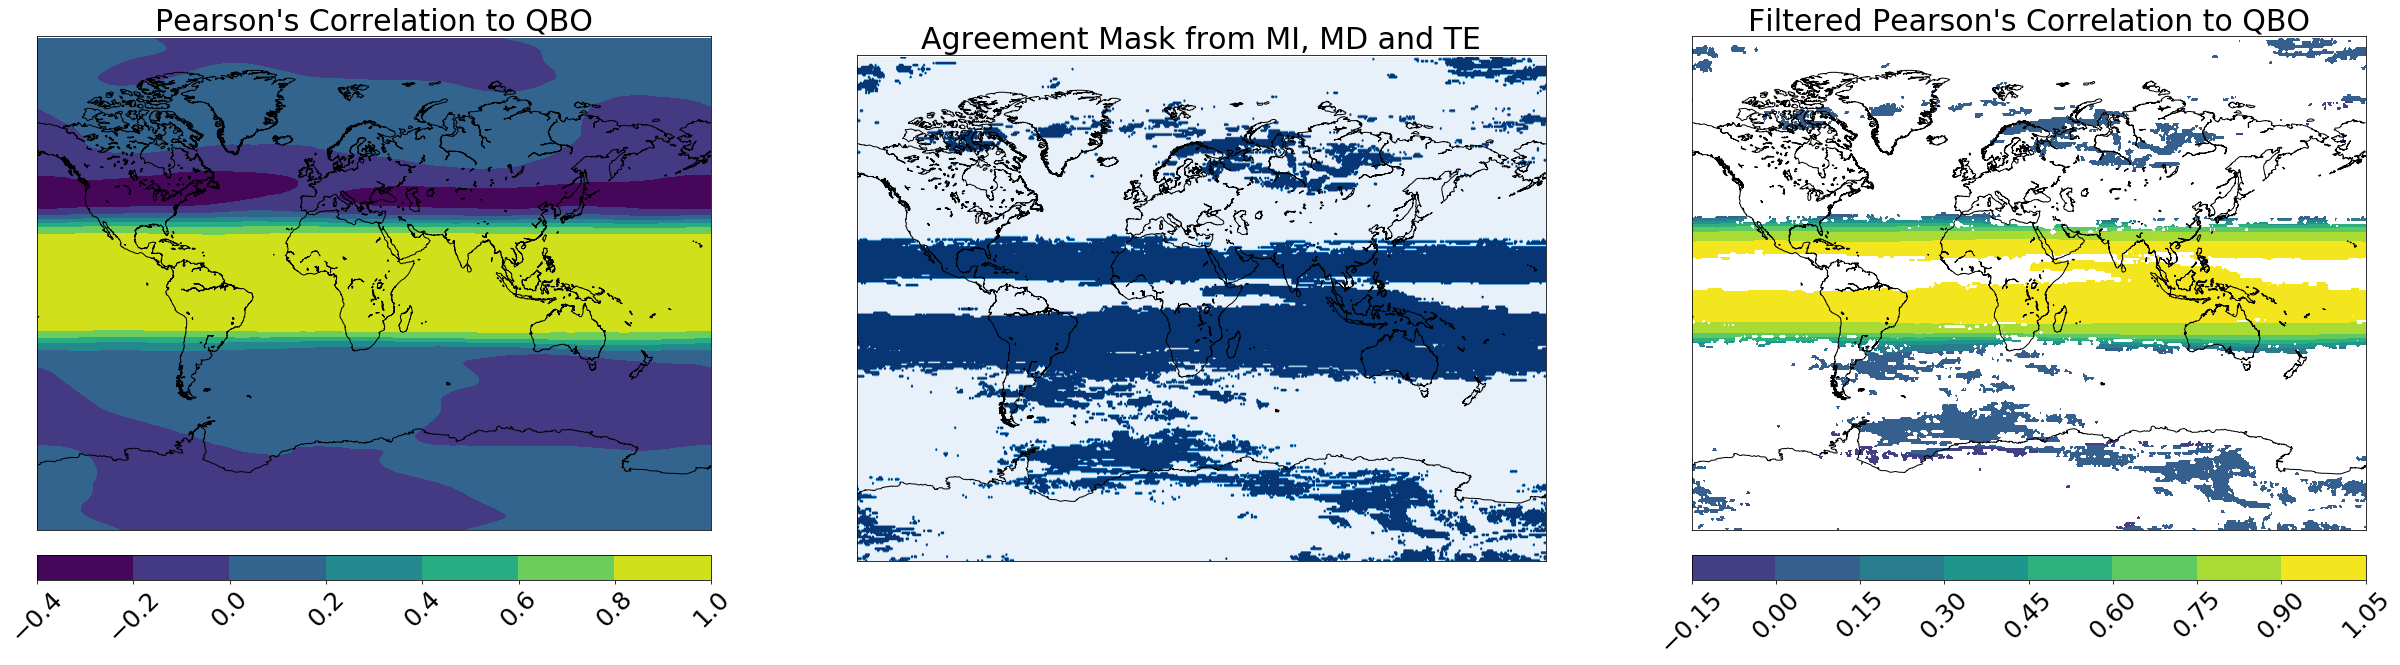

In [20]:
fig, ax = plt.pyplot.subplots(1, 3, figsize=(42, 10))
plots.plot_map(pearson_map, ax[0])
plots.plot_map(mask, ax[1], cmap=plt.cm.get_cmap("Blues"), colorbar=False)
plots.plot_map(filtered_pearson_map, ax[2], overwrite_colorbar_boundaries=True, colorbar_min=np.min(pearson_map), colorbar_max=1)
titles = ["Pearson's Correlation to QBO", "Agreement Mask from MI, MD and TE", "Filtered Pearson's Correlation to QBO"]
plots.annotate(ax, column_labels=titles, column_count=3)

<h1>Size of agreement areas over time</h1>

In [17]:
measures = [sim.pearson_correlation_abs, sim.mutual_information, comp.invert(sim.manhattan_distance), comp.invert(sim.transfer_entropy)]

In [18]:
level = ["3 hPa", "30 hPa", "70 hPa", "300 hPa"]

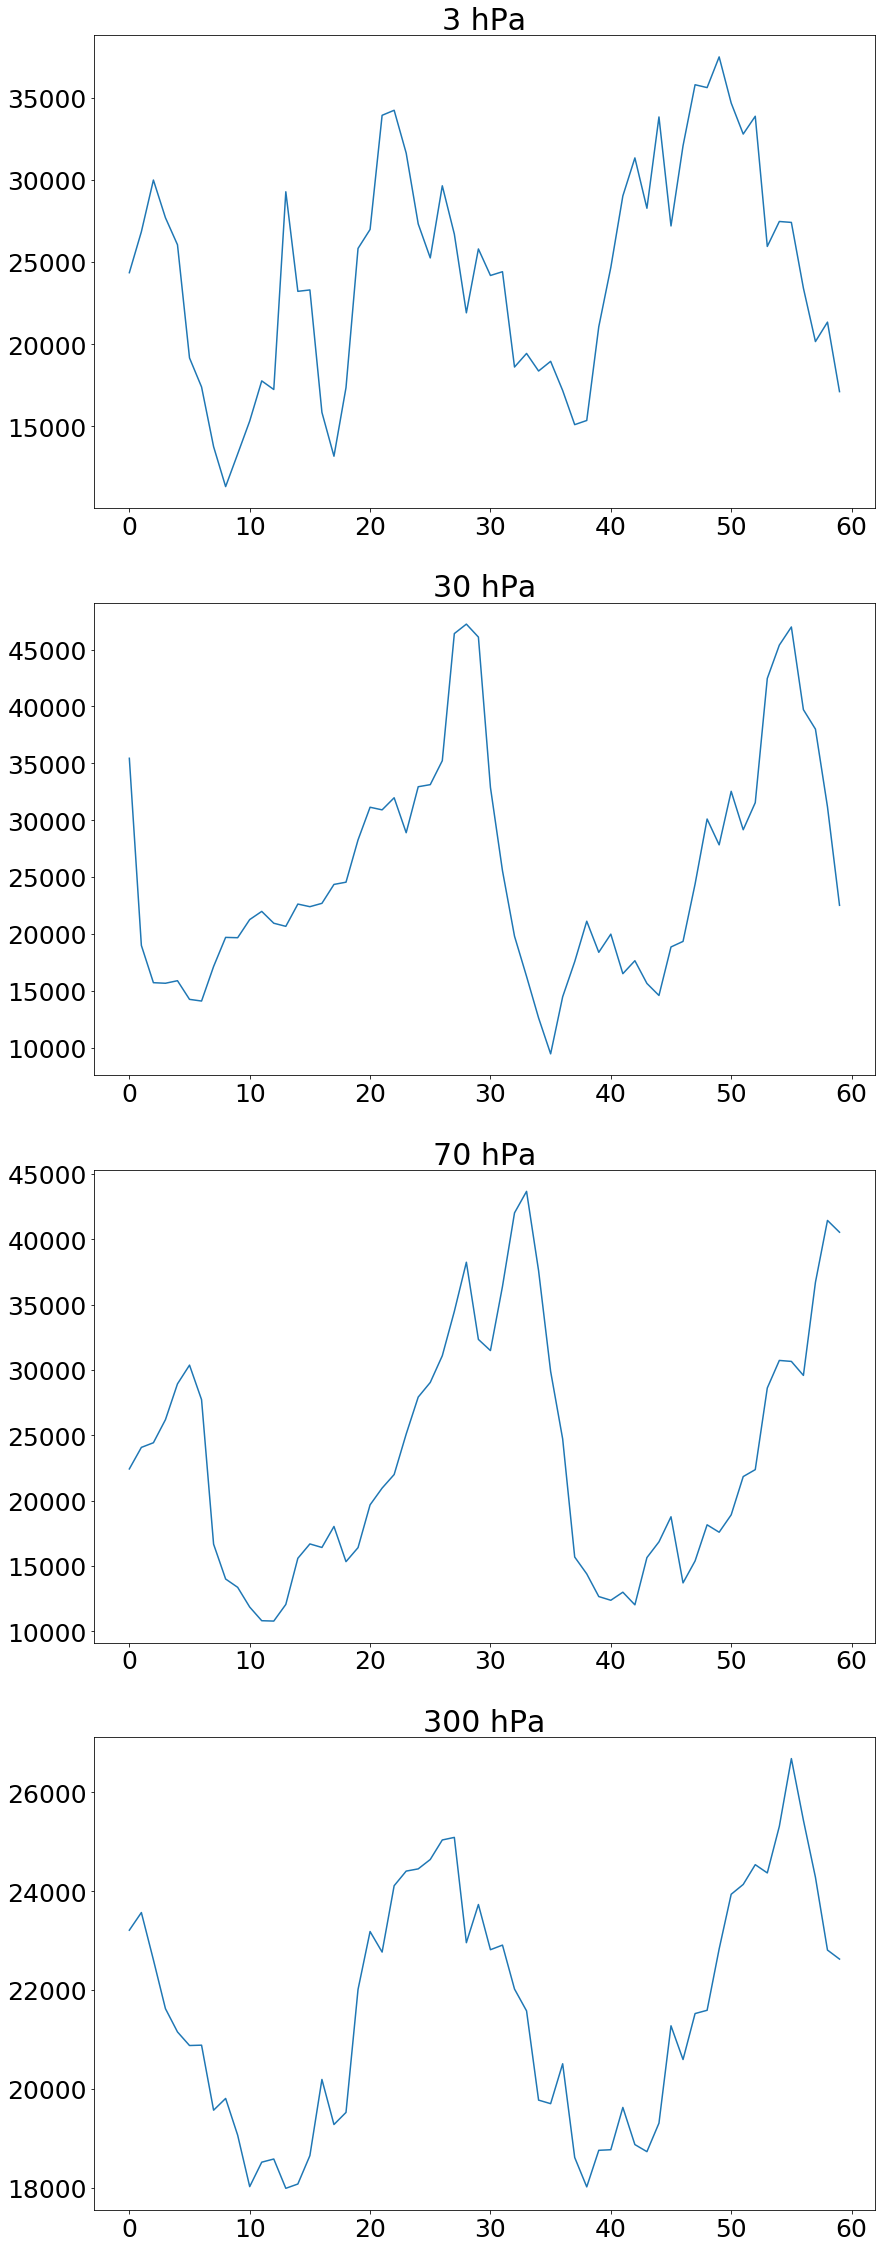

In [19]:
fig, ax = plt.pyplot.subplots(4, 1, figsize=(14, 4 * 10))
for i, dataset in enumerate([u_l3, u_l30, u_l70, u_l300]):
    nums_agreement_points = []
    for delay in range(0, 60, 1):
        if delay > 0: 
            qbo_equator_shortened = qbo_equator[:-delay]
        else:
            qbo_equator_shortened = qbo_equator
        dataset_delayed = dataset[delay:, :, :, :]
        agreement = calc.calculate_filtered_agreement_areas(dataset_delayed, qbo_equator_shortened, measures, strength_threshold, agreement_threshold, strength_func=strength_func, agreement_func=agreement_func, scaling_func=scaling)
        num = np.sum(agreement)
        nums_agreement_points.append(num)
    ax[i].plot(nums_agreement_points)
    ax[i].set_title(level[i])